In [1]:
import tarfile
import pandas as pd
import numpy as np
from nilearn import plotting
import os
import nibabel as nib
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline
np.random.seed(1)

In [2]:
# !python3

Python 3.6.3 (default, Dec 11 2017, 21:18:04) 
[GCC Intel(R) C++ gcc 5.4 mode] on linux
Type "help", "copyright", "credits" or "license" for more information.
>>> 
Traceback (most recent call last):
  File "<stdin>", line 1, in <module>
KeyboardInterrupt
>>> 

In [3]:
!hostname

c405-071.stampede2.tacc.utexas.edu


In [1]:
!pwd

/home1/05982/tg852820


In [2]:
os.chdir('/scratch/05982/tg852820')

In [9]:
!ls

copy_fs_t1_nacc.tar  fs_t1  TeamA_data_nacc_diagnosis_scratch.xlsx


### 1. Data cleaning

In [10]:
import tarfile

In [3]:
tar = tarfile.open("copy_fs_t1_nacc.tar")
# get a list of tarInfo objects
directory = tar.getmembers()
# extract names from the objects to get a directory list
directory = [file.name.split("/")[1] for file in directory if file.isfile()]
# 7862 files in total
image_info = pd.DataFrame(directory,columns=["filename"])
image_info["NACCMRFI"] = image_info["filename"].apply(lambda x: x.split("_")[0])
image_info.head()

,filename,NACCMRFI
0,mri71_MPRAGE_T1_AX_20100921133637_15.nii.gz,mri71
1,mri3579_t1_fl2d_sag_20100610142105_3.nii.gz,mri3579
2,mri4375_MPRAGE_20110105152454_2.nii.gz,mri4375
3,mri4908_SAG_T1_20130424203248_2.nii.gz,mri4908
4,mri1061_FSPGR_rhuser1=-376_rhuser2=10_20130620...,mri1061


In [12]:
# !pip3 install --user xlrd

In [ ]:
import xlrd

In [ ]:
# load data_nacc_diagnosis.csv to match the diagnosis with image data
clinic_info = pd.read_excel("TeamA_data_nacc_diagnosis_scratch.xlsx")
clinic_info.head()

In [15]:
# remove columns we don't use
temp1 = clinic_info.iloc[:,1:3]
temp1.head()

,NACCMRFI,diagnosis_0normal_1normaltomci_2mci_3ad_4otherdementia
0,mri1140.zip,0
1,mri5864.zip,0
2,mri5863.zip,0
3,mri4786.zip,0
4,mri7855.zip,0


In [16]:
# check the duplicate situation, generate a list of indices to drop
temp2 = temp1.groupby("NACCMRFI").nunique()
# drop the conflicting-diagnoses cases: 12 cases removed
duplicates = temp2[temp2["diagnosis_0normal_1normaltomci_2mci_3ad_4otherdementia"]==2].index
temp3 = temp1.set_index("NACCMRFI").drop(labels=list(duplicates),axis=0)
# drop normal duplicates, 81 cases removed
diag_info = temp3.reset_index().drop_duplicates()
# modify ID information
diag_info["NACCMRFI"] = diag_info["NACCMRFI"].apply(lambda x: x.split(".")[0])
diag_info.head()

,NACCMRFI,diagnosis_0normal_1normaltomci_2mci_3ad_4otherdementia
0,mri1140,0
1,mri5864,0
2,mri5863,0
3,mri4786,0
4,mri7855,0


In [17]:
# merge the two files and see the matching results
match_info = image_info.merge(diag_info, left_on="NACCMRFI", right_on="NACCMRFI", how="outer")
act_dataset_len = len(match_info[(match_info["diagnosis_0normal_1normaltomci_2mci_3ad_4otherdementia"].isna()==False)&(match_info["filename"].isna()==False)])
whole_dataset_len = len(match_info)
print("There are %s data points in total."%whole_dataset_len)
print("Only %s can be matched to the diagnosis information which can be used as the dataset."%act_dataset_len)

# take all useful data points
data_info = match_info[(match_info["diagnosis_0normal_1normaltomci_2mci_3ad_4otherdementia"].isna()==False)&(match_info["filename"].isna()==False)]


There are 8836 data points in total.
Only 6272 can be matched to the diagnosis information which can be used as the dataset.


In [19]:
data_info['Normal'] = data_info["diagnosis_0normal_1normaltomci_2mci_3ad_4otherdementia"].apply(lambda x: 1 if x==0 else 0)
data_info['NormalToMCI'] = data_info["diagnosis_0normal_1normaltomci_2mci_3ad_4otherdementia"].apply(lambda x: 1 if x==1 else 0)
data_info['MCI'] = data_info["diagnosis_0normal_1normaltomci_2mci_3ad_4otherdementia"].apply(lambda x: 1 if x==2 else 0)
data_info['AD'] = data_info["diagnosis_0normal_1normaltomci_2mci_3ad_4otherdementia"].apply(lambda x: 1 if x==3 else 0)
data_info['OtherDementia'] = data_info["diagnosis_0normal_1normaltomci_2mci_3ad_4otherdementia"].apply(lambda x: 1 if x==4 else 0)

/opt/apps/intel17/python3/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/apps/intel17/python3/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/apps/intel17/python3/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

In [20]:
data_info.head(30)

,filename,NACCMRFI,diagnosis_0normal_1normaltomci_2mci_3ad_4otherdementia,Normal,NormalToMCI,MCI,AD,OtherDementia
0,mri71_MPRAGE_T1_AX_20100921133637_15.nii.gz,mri71,3.0,0,0,0,1,0
1,mri3579_t1_fl2d_sag_20100610142105_3.nii.gz,mri3579,3.0,0,0,0,1,0
2,mri3579_MPRAGE_adni1mm_ipat_20100610142105_11....,mri3579,3.0,0,0,0,1,0
3,mri3579_ep2d_t1w_128_2mm_20100610142105_19.nii.gz,mri3579,3.0,0,0,0,1,0
4,mri3579_MPRAGE_adni1mm_ipat_20100610142105_13....,mri3579,3.0,0,0,0,1,0
5,mri4375_MPRAGE_20110105152454_2.nii.gz,mri4375,2.0,0,0,1,0,0
6,mri4908_SAG_T1_20130424203248_2.nii.gz,mri4908,4.0,0,0,0,0,1
7,mri4908_AX_T1_20130424203248_8.nii.gz,mri4908,4.0,0,0,0,0,1
8,mri1061_FSPGR_rhuser1=-376_rhuser2=10_20130620...,mri1061,3.0,0,0,0,1,0
14,mri376_Ax_FSPGR_BRAVO_20130109081555_10.nii.gz,mri376,0.0,1,0,0,0,0


In [23]:
number_files_loaded = 3
sample_list = data_info.iloc[:number_files_loaded, :]["filename"]
sample_data_list = list()
for filename in sample_list:
    # or is it better to use get_fdata()?
    a = nib.load("fs_t1/"+filename).get_data()
    sample_data_list.append(a)
sample_dataset = np.array(sample_data_list, dtype=np.float32)
batch_size, height, width, depth = sample_dataset.shape
channels = 1  # gray-scale instead of RGB
s = sample_dataset.reshape(number_files_loaded, 256, 256, 256, 1)

In [34]:
sample_dataset

array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
    

In [24]:
y = data_info.iloc[:number_files_loaded, 4:9]
y

,NormalToMCI,MCI,AD,OtherDementia
0,0,0,1,0
1,0,0,1,0
2,0,0,1,0


In [25]:
def create_placeholders(n_D0, n_H0, n_W0, n_C0, n_y):
    """
    Creates the placeholders for the tensorflow session.

    Arguments:
    n_D0 -- scalar, depth of an input image
    n_H0 -- scalar, height of an input image
    n_W0 -- scalar, width of an input image
    n_C0 -- scalar, number of channels of the input
    n_y -- scalar, number of classes

    Returns:
    X -- placeholder for the data input, of shape [None, n_D0, n_H0, n_W0, n_C0] and dtype "float"
    Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float"
    """

    X = tf.placeholder(shape=(None, n_D0, n_H0, n_W0, n_C0), dtype=tf.float32)
    Y = tf.placeholder(shape=(None, n_y), dtype=tf.float32)

    return X, Y

In [26]:
def forward_propagation(X, parameters=None):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED

    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "W2"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """

    # Retrieve the parameters from the dictionary "parameters"


    # CONV2D: filters W1, stride of 1, padding 'SAME', RELU
    # output_size = (3, 256, 256, 256, 8)
    A1 = tf.layers.conv3d(X, filters=8, kernel_size=4,
                          strides=1, padding="SAME", activation=tf.nn.relu)
    
    # MAXPOOL: window 8x8, sride 8, padding 'SAME'
    # output_size = (3, 32, 32, 32, 8)
    P1 = tf.layers.max_pooling3d(A1, pool_size=8, strides=8, padding="SAME")
    
    # CONV2D: filters W2, stride 1, padding 'SAME'
    # output_size = (3, 32, 32, 32, 16)
    A2 = tf.layers.conv3d(P1, filters=16, kernel_size=2,
                          strides=1, padding="SAME", activation=tf.nn.relu)
    
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    # output_size = (3, 8, 8, 8, 16)
    P2 = tf.layers.max_pooling3d(A2, pool_size=4, strides=4, padding="SAME") 
    
    # FLATTEN
    # output_size = (3, 8192)
    P2 = tf.contrib.layers.flatten(P2)   
    
    # FULLY-CONNECTED without non-linear activation function (not not call softmax).
    # 5 neurons in output layer. Hint: one of the arguments should be "activation_fn=None"
    # output_size = (3,5)
    Z3 = tf.contrib.layers.fully_connected(P2, 5, activation_fn=None)   


    return Z3

In [27]:
def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    cost = tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y)
    cost = tf.reduce_mean(cost)
    
    return cost

In [31]:
(number_file_loaded, n_D0, n_H0, n_W0, n_C0) = s.shape
n_y = 5
with tf.Session() as sess:
    X, Y = create_placeholders(n_D0, n_H0, n_W0, n_C0, n_y)
#     parameters = initialize_parameters()
    Z3 = forward_propagation(X)
    cost = compute_cost(Z3, Y)
    init = tf.global_variables_initializer()
    sess.run(init)
    temp_cost = sess.run(cost, {X: s, Y: y})

ValueError: Cannot feed value of shape (3, 4) for Tensor 'Placeholder_7:0', which has shape '(?, 5)'

In [ ]:
temp_cost

### 2. Plot Images

In [14]:
# !pip3 install --user nilearn

In [15]:
import matplotlib.pyplot as plt

In [14]:
# !pip3 install --user nibabel

In [17]:
import warnings
warnings.filterwarnings('ignore')

In [18]:
from nilearn import plotting
import os
import nibabel as nib
import tensorflow as tf

In [34]:
# load 5 sample images
sample_list = data_info.iloc[:5,:]["filename"]
sample_data_list = list()
for filename in sample_list:
#     file=tar.extract("fs_t1/"+filename)
    a = nib.load("fs_t1/"+filename).get_data()  # or is it better to use get_fdata()?
    sample_data_list.append(a)
sample_dataset = np.array(sample_data_list,dtype=np.float32)


In [36]:
sample_dataset.shape

(5, 256, 256, 256)

In [43]:
s = sample_dataset.reshape(5,256,256,256,1)

In [44]:
s.shape

(5, 256, 256, 256, 1)

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline    

In [46]:
for image in s:
    plt.imshow(image,cmap="gray")
    plt.show()

In [47]:
batch_size, height, width, depth = sample_dataset.shape
channels = 1 # gray-scale instead of RGB
s = sample_dataset.reshape(5,256,256,256,1)

In [ ]:
# create 3 filters (2 filters for 2D)
filters = np.zeros(shape=(7,7,7,channels,3),dtype=np.float32) # kernel size is 7 here, might not be optimal
filters[3,:,:,:,0] = 1 # horizontal line
filters[:,3,:,:,1] = 1 # vertical line
filters[:,:,3,:,2] = 1 # another dimension line

# # create a graph with input X plus a convolutional layer applying the 3 filters
X = tf.placeholder(tf.float32,shape=(None,height, width, depth,channels))
convolution = tf.nn.conv3d(X, filters, strides=[1, 4, 4, 4, 1], padding='SAME')

with tf.Session() as sess:
    output = sess.run(convolution,feed_dict={X:s})

In [26]:
output.shape

NameError: name 'output' is not defined

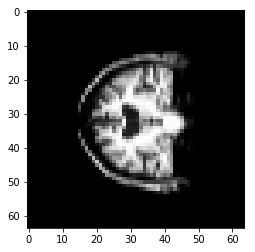

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(output[0,:,:,32,1],cmap="gray")
plt.show()

In [19]:
"""
tf.nn.conv3d(
    input,
    filter,
    strides,
    padding,
    data_format='NDHWC',
    name=None
    
    
    input = x 
    filter = W 
    stride = [1,1,1,1,1]
    padding='SAME'
    
) """

def module_conv3d(x,weight_shape,bias_shape):
    print(weight_shape)
    sizeIn = weight_shape[0] * weight_shape[1] * weight_shape[2]
    
    
    weight_init = tf.random_normal_initializer(stddev=(2.0/sizeIn)**0.5)
    W = tf.get_variable("W", weight_shape, initializer=weight_init)
    # initialize bias with zeros
    bias_init = tf.constant_initializer(value=0)
    b = tf.get_variable("b", bias_shape, initializer=bias_init)
    return tf.nn.relu(tf.nn.bias_add(tf.nn.conv3d(x, W, strides=[1, 1, 1, 1, 1], padding='SAME'), b))
                        

In [20]:
s.shape

(5, 256, 256, 256, 1)

In [21]:
s_1=s[0].reshape(256,256,256)

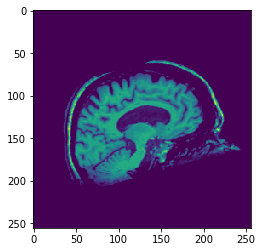

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(s_1[120].astype(np.uint8))

In [23]:
!pwd

/scratch/05982/tg852820


In [27]:
# !pip3 install --user tensorflow.contrib.keras.python.keras

In [28]:
# from tensorflow.contrib.keras import backend as K
# !pip3 install tensorflow.contrib.keras.python.keras

In [27]:
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
IMAGE_DEPTH = 256
batch_size = 5
samples = 100
volume_shape = [IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH]
input_shape = [batch_size, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH, 1]
n_epochs = 100


# training related variables
#     n_batches = int((samples)/batch_size)
padding = 'SAME'
stride = [1,1,1]
learning_rate = 0.001
noise_factor = 0.3


inputs_ = tf.placeholder(tf.float32, input_shape, name='inputs')
targets_ = tf.placeholder(tf.float32, input_shape, name='targets')

#network 14
#encoder
conv1 = tf.layers.conv3d(inputs= inputs_, filters=16, kernel_size=(3,3,3), padding= padding, strides = stride, activation=tf.nn.relu)
maxpool1 = tf.layers.max_pooling3d(conv1, pool_size=(2,2,2), strides=(2,2,2), padding= padding)
conv2 = tf.layers.conv3d(inputs=maxpool1, filters=32, kernel_size=(3,3,3), padding= padding, strides = stride, activation=tf.nn.relu)
maxpool2 = tf.layers.max_pooling3d(conv2, pool_size=(3,3,3), strides=(3,3,3), padding= padding)
# conv3 = tf.layers.conv3d(inputs=maxpool2, filters=96, kernel_size=(2,2,2), padding= padding , strides = stride, activation=tf.nn.relu)
# maxpool3 = tf.layers.max_pooling3d(conv3, pool_size=(2,2,2), strides=(2,2,2), padding= padding)

# decoder
unpool1 = tf.keras.backend.resize_volumes(maxpool2,2,2,2,"channels_last")
deconv1 = tf.layers.conv3d_transpose(inputs=unpool1, filters=96, kernel_size=(2,2,2), padding= padding , strides = stride, activation=tf.nn.relu)
unpool2 = tf.keras.backend.resize_volumes(deconv1,3,3,3,"channels_last")
deconv2 = tf.layers.conv3d_transpose(inputs=unpool2, filters=32, kernel_size=(3,3,3), padding= padding , strides = stride, activation=tf.nn.relu)
# unpool3 = tf.keras.backend.resize_volumes(deconv2,2,2,2,"channels_last")
# deconv3 = tf.layers.conv3d_transpose(inputs=unpool3, filters=16, kernel_size=(3,3,3), padding= padding , strides = stride, activation=tf.nn.relu)

# output = tf.layers.dense(inputs=deconv3, units=1)
# output = tf.reshape(output, input_shape)

# loss = tf.divide(tf.norm(tf.subtract(targets_, output), ord = 'fro', axis = [1,2,3]), tf.norm(targets_, ord = 'fro', axis = [1,2,3]))
# cost = tf.reduce_mean(loss)
# opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)
# all_saver = tf.train.Saver(max_to_keep = None)

In [28]:

init_op = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init_op)
    output = sess.run(deconv2,feed_dict={inputs_:s})



ResourceExhaustedError: OOM when allocating tensor with shape[5,260,260,260,96] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator mklcpu
	 [[Node: conv3d_transpose_1/conv3d_transpose = Conv3DBackpropInputV2[T=DT_FLOAT, Tshape=DT_INT32, data_format="NDHWC", dilations=[1, 1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1, 1], _device="/job:localhost/replica:0/task:0/device:CPU:0"](conv3d_transpose_1/stack, conv3d_transpose_1/kernel/read, concat_5)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'conv3d_transpose_1/conv3d_transpose', defined at:
  File "/opt/apps/intel17/python3/3.6.3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/apps/intel17/python3/3.6.3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/apps/intel17/python3/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/opt/apps/intel17/python3/3.6.3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/opt/apps/intel17/python3/3.6.3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/opt/apps/intel17/python3/3.6.3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/opt/apps/intel17/python3/3.6.3/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/opt/apps/intel17/python3/3.6.3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/opt/apps/intel17/python3/3.6.3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/opt/apps/intel17/python3/3.6.3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/opt/apps/intel17/python3/3.6.3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/opt/apps/intel17/python3/3.6.3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/opt/apps/intel17/python3/3.6.3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 281, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/opt/apps/intel17/python3/3.6.3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 232, in dispatch_shell
    handler(stream, idents, msg)
  File "/opt/apps/intel17/python3/3.6.3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 397, in execute_request
    user_expressions, allow_stdin)
  File "/opt/apps/intel17/python3/3.6.3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/opt/apps/intel17/python3/3.6.3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/opt/apps/intel17/python3/3.6.3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/opt/apps/intel17/python3/3.6.3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/opt/apps/intel17/python3/3.6.3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-27-7d7d88d7242d>", line 35, in <module>
    deconv2 = tf.layers.conv3d_transpose(inputs=unpool2, filters=32, kernel_size=(3,3,3), padding= padding , strides = stride, activation=tf.nn.relu)
  File "/home1/05982/tg852820/.local/lib/python3.6/site-packages/tensorflow/python/layers/convolutional.py", line 1444, in conv3d_transpose
    return layer.apply(inputs)
  File "/home1/05982/tg852820/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py", line 774, in apply
    return self.__call__(inputs, *args, **kwargs)
  File "/home1/05982/tg852820/.local/lib/python3.6/site-packages/tensorflow/python/layers/base.py", line 329, in __call__
    outputs = super(Layer, self).__call__(inputs, *args, **kwargs)
  File "/home1/05982/tg852820/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py", line 703, in __call__
    outputs = self.call(inputs, *args, **kwargs)
  File "/home1/05982/tg852820/.local/lib/python3.6/site-packages/tensorflow/python/keras/layers/convolutional.py", line 1031, in call
    padding=self.padding.upper())
  File "/home1/05982/tg852820/.local/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 1478, in conv3d_transpose
    name=name)
  File "/home1/05982/tg852820/.local/lib/python3.6/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 1816, in conv3d_backprop_input_v2
    data_format=data_format, dilations=dilations, name=name)
  File "/home1/05982/tg852820/.local/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home1/05982/tg852820/.local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3414, in create_op
    op_def=op_def)
  File "/home1/05982/tg852820/.local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1740, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[5,260,260,260,96] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator mklcpu
	 [[Node: conv3d_transpose_1/conv3d_transpose = Conv3DBackpropInputV2[T=DT_FLOAT, Tshape=DT_INT32, data_format="NDHWC", dilations=[1, 1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1, 1], _device="/job:localhost/replica:0/task:0/device:CPU:0"](conv3d_transpose_1/stack, conv3d_transpose_1/kernel/read, concat_5)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [ ]:
output.shape

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

w = 10
h = 10
fig = plt.figure(figsize=(20, 20))
columns = 4
rows = 1
# for i in range(1, columns*rows +1):
#     img = np.random.randint(10, size=(h,w))
#     fig.add_subplot(rows, columns, i)
#     plt.imshow(img)
img = s[0, :, 128, :, 0]
fig.add_subplot(rows, columns, 1)
plt.imshow(img)

img = output[0, :, 70, :, 4]
fig.add_subplot(rows, columns, 2)
plt.imshow(img)

img = output[0, :,67, :, 16]
fig.add_subplot(rows, columns, 3)
plt.imshow(img)

img = output[0, :, 70, :, 8]
fig.add_subplot(rows, columns, 4)
plt.imshow(img)

plt.show()